## CLARA multicore scaling

In [1]:
import json
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.autolayout'] = True

### Parameters

In [2]:
params = {
    'date': '2022-07-29',
    'host': 'nid004843',
    'chain': ['MAGFIELDS', 'FTCAL', 'FTHODO', 'FTEB', 'DCCR', 'MLTD', 'DCHAI', 'FTOFHB', 'EC', 'CVTFP', 'CTOF', 'CND', 'BAND', 'HTCC', 'LTCC', 'EBHB', 'DCTB', 'FMT', 'CVTSP', 'FTOFTB', 'EBTB', 'RICH', 'RTPC'],
    'input_file': './clas_006302.evio.00005-00009.hipo',
    'output_file': '/pscratch/sd/t/tylern/clas12/recon/test.hipo',
    'n_events': '2000',
    'jvm_options': ''
}

print(json.dumps(params, indent=4))

{
    "date": "2022-07-29",
    "host": "nid004843",
    "chain": [
        "MAGFIELDS",
        "FTCAL",
        "FTHODO",
        "FTEB",
        "DCCR",
        "MLTD",
        "DCHAI",
        "FTOFHB",
        "EC",
        "CVTFP",
        "CTOF",
        "CND",
        "BAND",
        "HTCC",
        "LTCC",
        "EBHB",
        "DCTB",
        "FMT",
        "CVTSP",
        "FTOFTB",
        "EBTB",
        "RICH",
        "RTPC"
    ],
    "input_file": "./clas_006302.evio.00005-00009.hipo",
    "output_file": "/pscratch/sd/t/tylern/clas12/recon/test.hipo",
    "n_events": "2000",
    "jvm_options": ""
}


### Benchmark

In [3]:
benchmark_data = """\
Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator
1,0.07,0.01,0.09,0.14,0.04,21.03,14.24,45.70,1.25,0.75,147.46,0.85,0.42,0.03,0.05,0.04,0.41,148.21,0.02,15.12,1.40,0.92,0.35,0.03,3.54,402.20,411.61
2,0.07,0.01,0.08,0.12,0.04,21.04,13.58,45.86,1.29,0.64,148.70,0.77,0.40,0.03,0.04,0.06,0.41,148.23,0.03,15.16,1.33,0.84,0.33,0.02,3.56,402.63,205.93
4,0.06,0.01,0.08,0.15,0.04,23.50,18.02,55.02,1.58,0.80,169.71,0.92,0.46,0.02,0.04,0.04,0.44,166.12,0.02,17.04,1.58,0.86,0.32,0.02,3.65,460.52,117.75
6,0.06,0.02,0.08,0.18,0.04,30.70,25.79,73.08,2.25,1.19,219.32,1.64,0.67,0.03,0.06,0.04,0.63,211.60,0.03,21.71,2.36,1.09,0.38,0.03,3.87,596.86,101.30
8,0.07,0.02,0.09,0.19,0.04,32.65,25.68,76.67,2.15,1.20,229.57,1.41,0.53,0.02,0.05,0.04,0.60,221.95,0.03,22.70,2.23,1.09,0.36,0.02,3.95,623.32,79.50
10,0.07,0.01,0.10,0.19,0.04,33.63,25.33,77.25,2.35,1.20,235.91,1.72,0.61,0.03,0.04,0.04,0.56,227.46,0.03,23.36,2.30,1.06,0.34,0.02,3.88,637.53,65.18
12,0.08,0.02,0.07,0.19,0.03,34.16,25.58,78.59,1.95,1.28,246.13,1.56,0.60,0.03,0.03,0.03,0.53,237.62,0.03,24.64,2.14,1.03,0.33,0.02,3.96,660.62,56.35
14,0.08,0.01,0.09,0.16,0.03,35.78,26.83,81.10,2.26,1.20,255.95,1.68,0.64,0.03,0.04,0.02,0.56,240.29,0.02,24.67,2.53,1.05,0.37,0.01,4.02,679.45,49.94
16,0.06,0.01,0.08,0.15,0.05,35.77,27.21,81.99,1.97,1.27,264.13,1.68,0.75,0.02,0.05,0.05,0.55,244.78,0.02,24.85,2.44,1.09,0.38,0.03,3.98,693.34,44.80
18,0.07,0.02,0.11,0.17,0.03,38.15,28.20,82.99,2.10,1.14,263.67,1.67,0.71,0.02,0.05,0.04,0.65,248.28,0.03,25.96,2.46,1.11,0.41,0.02,4.01,702.08,40.50
20,0.08,0.02,0.11,0.16,0.03,38.71,27.86,83.14,2.03,1.36,273.61,1.78,0.73,0.02,0.04,0.03,0.52,248.33,0.02,26.00,1.99,1.07,0.39,0.02,4.06,712.09,37.19
22,0.09,0.02,0.09,0.17,0.02,37.44,28.00,81.93,2.40,1.27,268.30,1.74,0.62,0.02,0.04,0.04,0.58,244.25,0.02,26.03,2.23,1.02,0.42,0.01,4.04,700.78,33.49
24,0.08,0.02,0.10,0.14,0.03,39.01,28.04,84.22,2.30,1.22,270.86,1.52,0.58,0.02,0.02,0.02,0.58,249.96,0.02,25.51,2.17,1.12,0.37,0.02,3.98,711.93,31.29
26,0.06,0.02,0.08,0.19,0.04,38.64,28.06,81.95,2.39,1.26,268.44,1.70,0.61,0.02,0.05,0.03,0.50,242.38,0.02,25.02,2.17,1.16,0.38,0.02,3.99,699.18,28.59
28,0.08,0.02,0.07,0.16,0.04,38.57,29.59,86.72,2.41,1.32,278.31,1.66,0.56,0.02,0.06,0.03,0.54,252.13,0.02,25.66,2.43,1.07,0.38,0.02,4.09,725.97,27.70
30,0.07,0.02,0.09,0.18,0.04,39.27,31.67,87.37,2.44,1.25,276.82,1.69,0.52,0.02,0.05,0.02,0.54,250.74,0.02,26.32,2.32,1.06,0.41,0.01,4.08,726.99,26.04
32,0.07,0.01,0.09,0.18,0.04,40.08,31.01,86.72,2.23,1.25,281.97,1.59,0.57,0.02,0.04,0.03,0.58,252.52,0.02,25.97,2.26,1.15,0.38,0.02,4.08,732.88,24.76"""

df = pd.read_csv(StringIO(benchmark_data))

In [4]:
df['EvRate'] = 1000 / df['Orchestrator']

pd.options.display.max_columns = None
pd.options.display.precision = 2
df

,Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator,EvRate
0,1,0.07,0.01,0.09,0.14,0.04,21.03,14.24,45.70,1.25,0.75,147.46,0.85,0.42,0.03,0.05,0.04,0.41,148.21,0.02,15.12,1.40,0.92,0.35,0.03,3.54,402.20,411.61,2.43
1,2,0.07,0.01,0.08,0.12,0.04,21.04,13.58,45.86,1.29,0.64,148.70,0.77,0.40,0.03,0.04,0.06,0.41,148.23,0.03,15.16,1.33,0.84,0.33,0.02,3.56,402.63,205.93,4.86
2,4,0.06,0.01,0.08,0.15,0.04,23.50,18.02,55.02,1.58,0.80,169.71,0.92,0.46,0.02,0.04,0.04,0.44,166.12,0.02,17.04,1.58,0.86,0.32,0.02,3.65,460.52,117.75,8.49
3,6,0.06,0.02,0.08,0.18,0.04,30.70,25.79,73.08,2.25,1.19,219.32,1.64,0.67,0.03,0.06,0.04,0.63,211.60,0.03,21.71,2.36,1.09,0.38,0.03,3.87,596.86,101.30,9.87
4,8,0.07,0.02,0.09,0.19,0.04,32.65,25.68,76.67,2.15,1.20,229.57,1.41,0.53,0.02,0.05,0.04,0.60,221.95,0.03,22.70,2.23,1.09,0.36,0.02,3.95,623.32,79.50,12.58
5,10,0.07,0.01,0.10,0.19,0.04,33.63,25.33,77.25,2.35,1.20,235.91,1.72,0.61,0.03,0.04,0.04,0.56,227.46,0.03,23.36,2.30,1.06,0.34,0.02,3.88,637.53,65.18,15.34
6,12,0.08,0.02,0.07,0.19,0.03,34.16,25.58,78.59,1.95,1.28,246.13,1.56,0.60,0.03,0.03,0.03,0.53,237.62,0.03,24.64,2.14,1.03,0.33,0.02,3.96,660.62,56.35,17.75
7,14,0.08,0.01,0.09,0.16,0.03,35.78,26.83,81.10,2.26,1.20,255.95,1.68,0.64,0.03,0.04,0.02,0.56,240.29,0.02,24.67,2.53,1.05,0.37,0.01,4.02,679.45,49.94,20.02
8,16,0.06,0.01,0.08,0.15,0.05,35.77,27.21,81.99,1.97,1.27,264.13,1.68,0.75,0.02,0.05,0.05,0.55,244.78,0.02,24.85,2.44,1.09,0.38,0.03,3.98,693.34,44.80,22.32
9,18,0.07,0.02,0.11,0.17,0.03,38.15,28.20,82.99,2.10,1.14,263.67,1.67,0.71,0.02,0.05,0.04,0.65,248.28,0.03,25.96,2.46,1.11,0.41,0.02,4.01,702.08,40.50,24.69


### Plots

In [5]:
title = 'Scaling test - CLARA 4.3-SNAPSHOT - nid004843 - 2000 events'
xlim = (0, 34)
xticks = range(0, 34, 4)

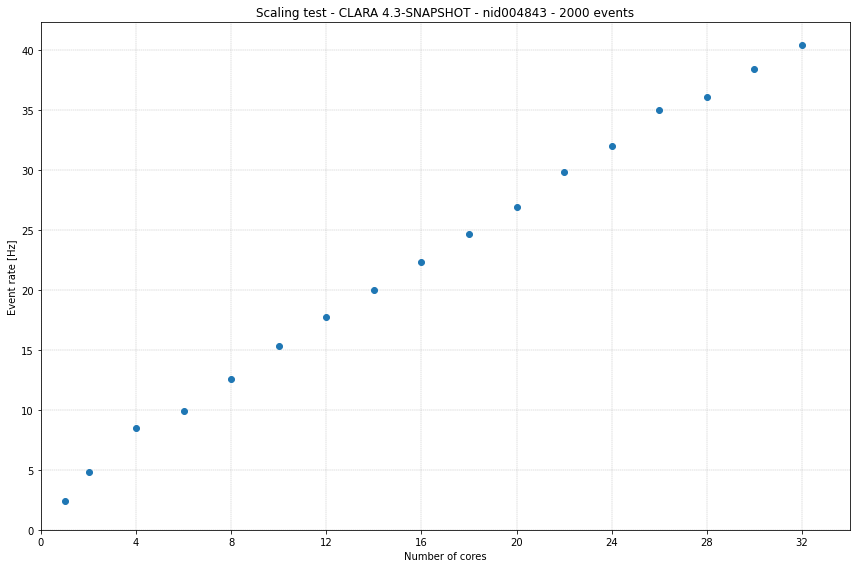

In [6]:
ax = df.plot(x='Cores', y='EvRate', style='o', legend=False, xlim=xlim, xticks=xticks)
ax.set_title(title)
ax.set_ylim(bottom=0)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Event rate [Hz]');

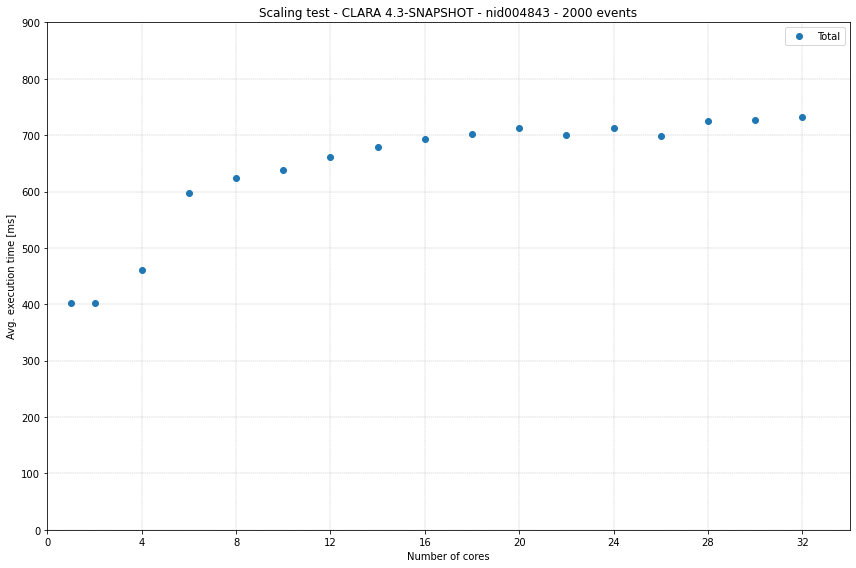

In [7]:
_, ax = plt.subplots()

df.plot(x='Cores', y='TOTAL', ax=ax, label='Total', style='o')

ax.set_title(title)
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(0, 900)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Avg. execution time [ms]')
ax.legend();